# Домашнее задание 3. Алгоритмы кластеризации

Основная задача этого задания -- реализация одного из алгоритмов кластеризации. Кроме того, мы научимся подбирать параметры алгоритма, визуализируем результат кластеризации и попытаемся проанализировать природу полученных кластеров.

In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
import sklearn.neighbors as nb
# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Cчитываем данные, полученные в результате выполнения предыдущего домашнего задания, в `data frame` библиотеки `pandas`. Конвертируем данные в массив `numpy`.

In [2]:
data_df = pd.read_csv("hw2_out.csv", sep="\t", header=0, index_col="uid")
x = data_df.values

In [3]:
pts_distance = smt.pairwise_distances(x)

Алгоритм кластеризации, который необходимо реализовать, выбирается на основании Вашего логина на портале Техносферы. При проверке домашнего задания бадут осуществляться проверка логина и соответствующего алгоритма.

In [4]:
algorithms = [
    u"Gaussian Mixture Model с использованием maximum a-posteriori для выбора кластера (параметр - k)",
    u"Hierarchical clustering с поддержкой single-linkage, complete-linkage, average-linkage (параметры - k, linkage)",
    u"DBSCAN. (параметры  - epsilon, min_pts)", 
    u"OPTICS. (параметры - epsilon, min_pts)"
]

my_algorithm = algorithms[hash("a.mandzhiev") % len(algorithms)]
print u"Реализуем алгоритм кластеризации '%s'" % my_algorithm

Реализуем алгоритм кластеризации 'DBSCAN. (параметры  - epsilon, min_pts)'


Алгоритм кластеризации должен удовлетворять следующему интерфейсу. Конструктор принимает набор параметров, необходимых для работы алгоритма кластеризации. Метод `fit` подсчитывает параметры модели и возвращает `self`. Метод `predict` возвращает вектор с индексами кластеров для поданных в него объектов `x`

In [5]:
class Clustering:
    NOISE = -1
    NOTVISITED = False
    VISITED = True
    """
    Implement clustering algorithm according 
    """
    def _expand_cluster(self, x, neighbours, point_id, cluster_id, visited):
        self._labels[point_id] = cluster_id
        core_nbrs = list(neighbours[point_id])
        while core_nbrs != []:
            cur_point = core_nbrs[0]
            if visited[cur_point] == self.NOTVISITED:
                visited[cur_point] = self.VISITED
                cur_neighbours = list(neighbours[cur_point])
                if len(cur_neighbours) >= self.min_pts:
                    for i in cur_neighbours:
                        if i not in core_nbrs:
                            core_nbrs.append(i)
                    #core_nbrs += list(set(cur_neighbours) - set(core_nbrs))
            if self._labels[cur_point] == 0:
                self._labels[cur_point] = cluster_id
            core_nbrs = core_nbrs[1:]
                
            
    
    def __init__(self, **kwargs):
        """
        Please add necessary algoritm parameters to class constructor.
        """
        self.eps = kwargs['epsilon']
        self.min_pts = kwargs['min_pts']
        return
        
    def fit(self, x, y=None):
        """
        Use data matrix x to compute model parameters
        """ 
        if not self.eps > 0.0:
            raise ValueError("Epsilon must be positive.")
        self.x_len = x.shape[0]
        visited = { a: self.NOTVISITED for a in range(self.x_len) }
        self._labels = [0] * self.x_len
        cluster_id = 0
        tree = nb.KDTree(x, leaf_size=10)
        neighbours = tree.query_radius(x, self.eps)
                                      
        for point_id in range(self.x_len):
            if visited[point_id] == self.NOTVISITED:
                if neighbours[point_id].shape[0] < self.min_pts:
                    self._labels[point_id] = self.NOISE
                else:
                    cluster_id += 1
                    self._expand_cluster(x, neighbours, point_id, cluster_id, visited)
        return self
    
    def predict(self, x):
        """
        Using computed model parameters predict cluster
        for all objects from x
        """
        return self._labels
    
    def fit_predict(self, x, y=None):
        self.fit(x, y)
        return np.array(self.predict(x))

Сначала проверим реализованный алгоритм кластеризации на классическом наборе данных [Iris](http://www.wikiwand.com/en/Iris_flower_data_set). Загрузим данные (они включены в библиотеку sklearn) и посмотрим на то, как они выглядят в двух проекциях (для простоты используем 2 класса из 3).

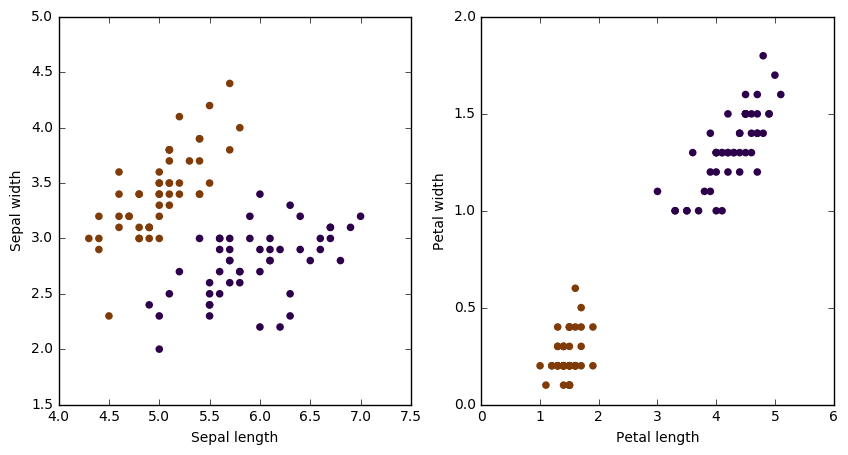

In [6]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

Видно, что классы разделяются, поэтому можно надеяться, что наш алгоритм "найдет" кластеры, соответствующие исходным классам. Результат работы реализованного алгоритма кластеризации предлагается сравнить с эталонной кластеризацией. Для этого предлагается изучить метрику ([adjusted rand score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)). В случае если значение этой метрики отличается от 1, предлагается поработать над улучшением реализации своего алгоритма.

In [7]:
try:
    pred_iris = Clustering(epsilon = 1.5, min_pts = 10).fit_predict(x_iris)
    print "Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris)
    pred_iris_lib = sc.DBSCAN(eps = 1.5, min_samples = 10).fit_predict(x_iris)
    print "Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(pred_iris_lib, pred_iris)
except ValueError as e:
    print e

Adjusted Rand index for iris is: 1.00
Adjusted Rand index for iris is: 1.00


Выбрать и реализовать критерий качества, на основании которого будут подбираться параметры модели. Варианты критериев:
- Инерция (сумма квадратов расстояний от каждой из точек до ближайшего к этой точке центроида)
- Средний диаметр (максимальное расстояние между точками в кластере) или радиус (расстояние от центроида до самой дальней от него точки в кластере)
- Sihouette

**Критерий качества необходимо выбрать таким образом, чтобы он подходил для реализованного алгоритма**

In [8]:
def dist_near_cluster(pts_distances, y, point):
    b = [np.mean(pts_distances[point][y == cluster]) for cluster in set(y) if cluster != y[point]]
    return np.min(b)

def quality(y, pts_distances):
    """
    Implement quality criterion of your choice
    """
    #compute inner distances
    amnt_labels = len(set(y))
    if amnt_labels == 1:
        return 1
    amnt_pts = len(y)
    a = np.zeros(amnt_pts)
    b = np.zeros(amnt_pts)
    for point in xrange(amnt_pts):
        mask = y == y[point]
        mask[point] = False
        a[point] = np.mean(pts_distances[point][mask])
    #compute nearest claster
    for point in xrange(amnt_pts):
            b[point] = dist_near_cluster(pts_distances, y, point)
    sil = np.mean(((b - a) / np.maximum(a, b)))
    return sil

Применим критерий для выбора параметров алгоритма. Предлагается изменить следующий код таким образом, чтобы кластеризация вызывалась с верным набором параметров. На графике можно будет увидеть зависимость критерия от параметров алгоритма. Необходимо выбрать оптимальные значения этих параметров.

sil: -0.0749869052758 ; eps =  0.08 ; min_pts =  18 ; cnt_claster =  7
sil: -0.0751017918335 ; eps =  0.08 ; min_pts =  19 ; cnt_claster =  7
sil: -0.0754926833608 ; eps =  0.08 ; min_pts =  20 ; cnt_claster =  7
sil: -0.0369647895656 ; eps =  0.08 ; min_pts =  21 ; cnt_claster =  6
sil: -0.0363053768976 ; eps =  0.08 ; min_pts =  22 ; cnt_claster =  6
sil: 0.0335281109856 ; eps =  0.08 ; min_pts =  23 ; cnt_claster =  5
sil: -0.0943130970846 ; eps =  0.08 ; min_pts =  24 ; cnt_claster =  6
sil: -0.0950990476233 ; eps =  0.08 ; min_pts =  25 ; cnt_claster =  6
sil: -0.095260727786 ; eps =  0.08 ; min_pts =  26 ; cnt_claster =  6
sil: 0.0306927822104 ; eps =  0.08 ; min_pts =  27 ; cnt_claster =  5
sil: -0.0834180911072 ; eps =  0.09 ; min_pts =  18 ; cnt_claster =  7
sil: -0.0828615583971 ; eps =  0.09 ; min_pts =  19 ; cnt_claster =  7
sil: -0.0395443912498 ; eps =  0.09 ; min_pts =  20 ; cnt_claster =  6
sil: -0.0414667141174 ; eps =  0.09 ; min_pts =  21 ; cnt_claster =  6
sil: -0.0

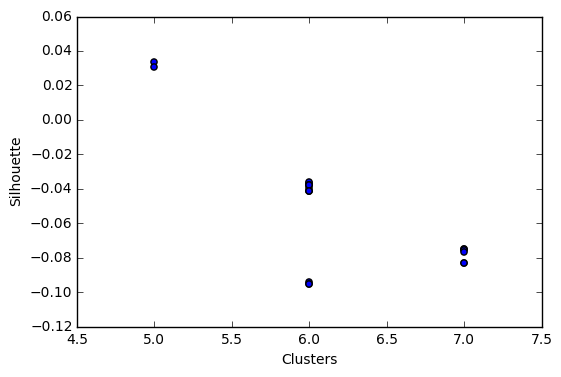

In [9]:
epsilons = [i/100. for i in range(8, 10)]
min_points = [i for i in range(18, 28)]
sil_max = -10
eps_max = 0
pts_min_max = 0
x_amnt_clusters = []
y_sil = []
new_x = np.zeros((100,x.shape[1]))
for epsil in epsilons:
    for min_point in min_points:
        cls = Clustering(epsilon = epsil, min_pts = min_point)
        y = cls.fit_predict(x)
        cur_sil = quality(y, pts_distance)
        if sil_max < cur_sil:
            sil_max = cur_sil
            eps_max = epsil
            pts_min_max = min_point
        print "sil:", cur_sil, "; eps = ", epsil, "; min_pts = ", min_point, "; cnt_claster = ", len(set(y))
        x_amnt_clusters.append(len(set(y)))
        y_sil.append(cur_sil)
print "maximum sil: ", sil_max, "; epsilon: ", eps_max, "; min_pts: ", pts_min_max
pl.xlabel('Clusters')
pl.ylabel('Silhouette')
pl.scatter(x_amnt_clusters, y_sil)
pl.gca().set_xlabel('Clusters')
pl.gca().set_ylabel('Silhouette')

Далее необходимо кластеризовать данные, используя выбранное количество кластеров, и визуализировать результат с помощью T-SNE. Внимание! На полном объеме данных данный алгоритм может работать существенное время. 

Визуализируем результаты кластеризации ([подсказка](http://anokhin.github.io/img/hw3_tsne-kmeans.png)). Можно ли сказать, что в двумерном пространстве объекты из одного кластера находятся недалеко? Какой вывод можно сделать о качестве кластеризации?

In [13]:
k = 5
cls = Clustering(epsilon = 0.08, min_pts=23)
y = cls.fit_predict(x)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 11435
[t-SNE] Computed conditional probabilities for sample 2000 / 11435
[t-SNE] Computed conditional probabilities for sample 3000 / 11435
[t-SNE] Computed conditional probabilities for sample 4000 / 11435
[t-SNE] Computed conditional probabilities for sample 5000 / 11435
[t-SNE] Computed conditional probabilities for sample 6000 / 11435
[t-SNE] Computed conditional probabilities for sample 7000 / 11435
[t-SNE] Computed conditional probabilities for sample 8000 / 11435
[t-SNE] Computed conditional probabilities for sample 9000 / 11435
[t-SNE] Computed conditional probabilities for sample 10000 / 11435
[t-SNE] Computed conditional probabilities for sample 11000 / 11435
[t-SNE] Computed conditional probabilities for sample 11435 / 11435
[t-SNE] Mean sigma: 0.006138
[t-SNE] Error after 100 iterations with early exaggeration: 1.339697
[t-SNE] Error

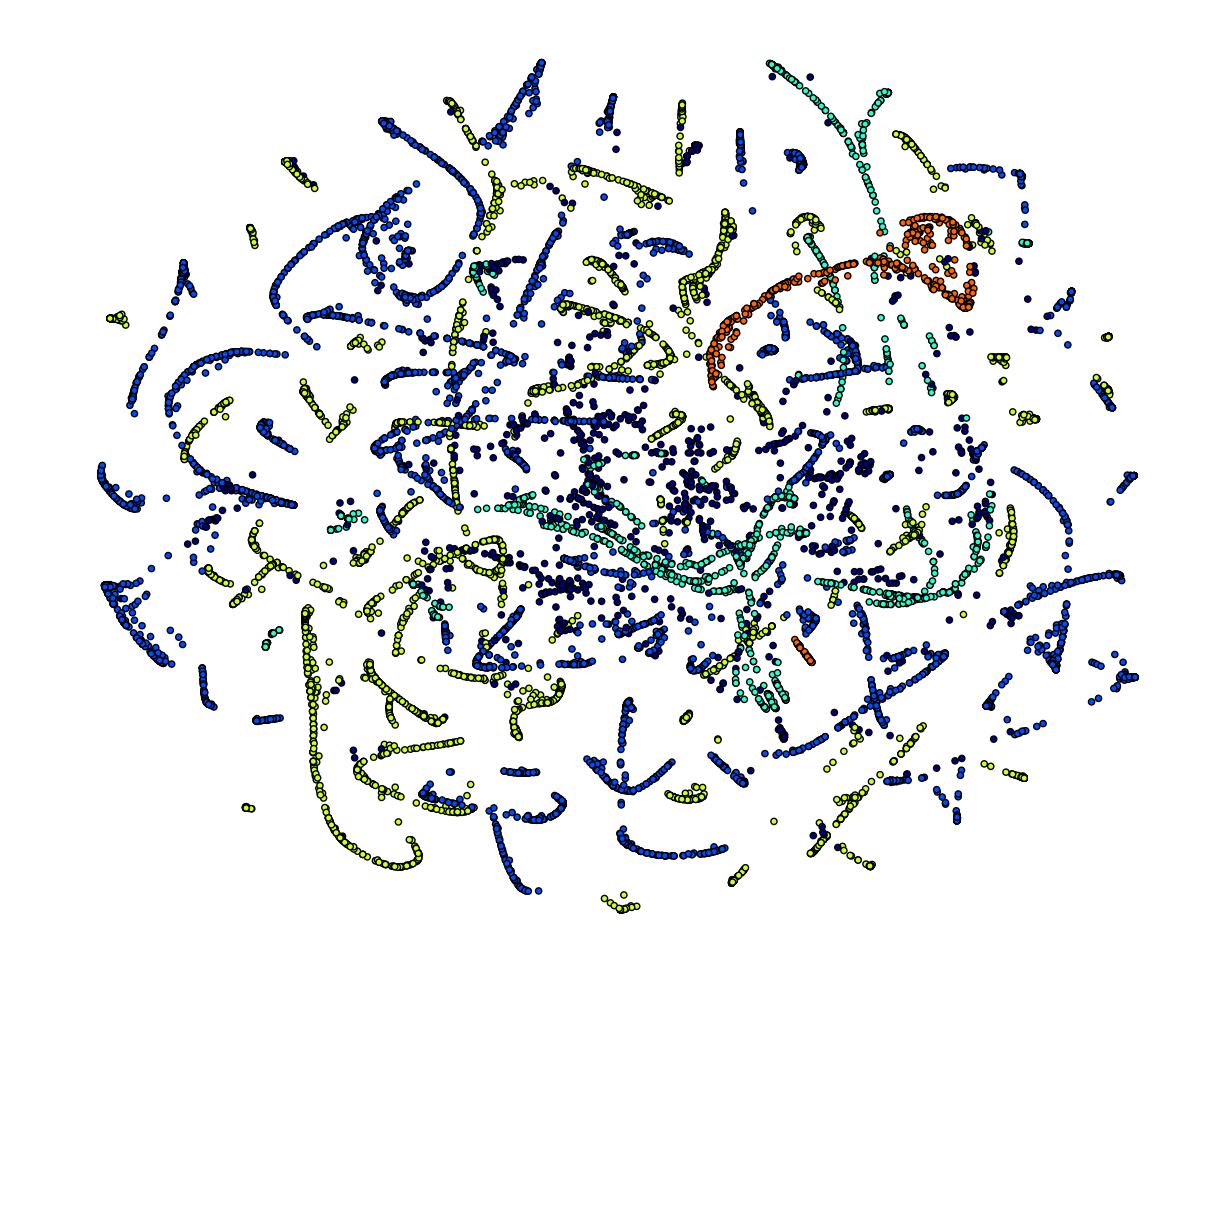

In [14]:
tsne = sm.TSNE(n_components=2, verbose=1, n_iter=1000)
z = tsne.fit_transform(x)

# Color map
cm = pl.get_cmap('jet')
pl.figure(figsize=(15, 15))
pl.scatter(z[:, 0], z[:, 1], c=map(lambda c: cm(1.0 * c / k), y))
pl.axis('off')
pl.show()

Попробуем проанализировать полученные кластеры. Для того, чтобы интерпретировать "суть" каждого из кластеров, построим [radar plot](http://www.wikiwand.com/en/Radar_chart), отображающий их центроиды. Посмотрите на графики и попробуйте объяснить, каким поведением можно охарактеризовать каждый из полученных кластеров? Есть ли среди кластеров похожие?

Реализация радара позаимствована отсюда: 
http://www.science-emergence.com/Matplotlib/MatplotlibGallery/RadarChartMatplotlibRougier/

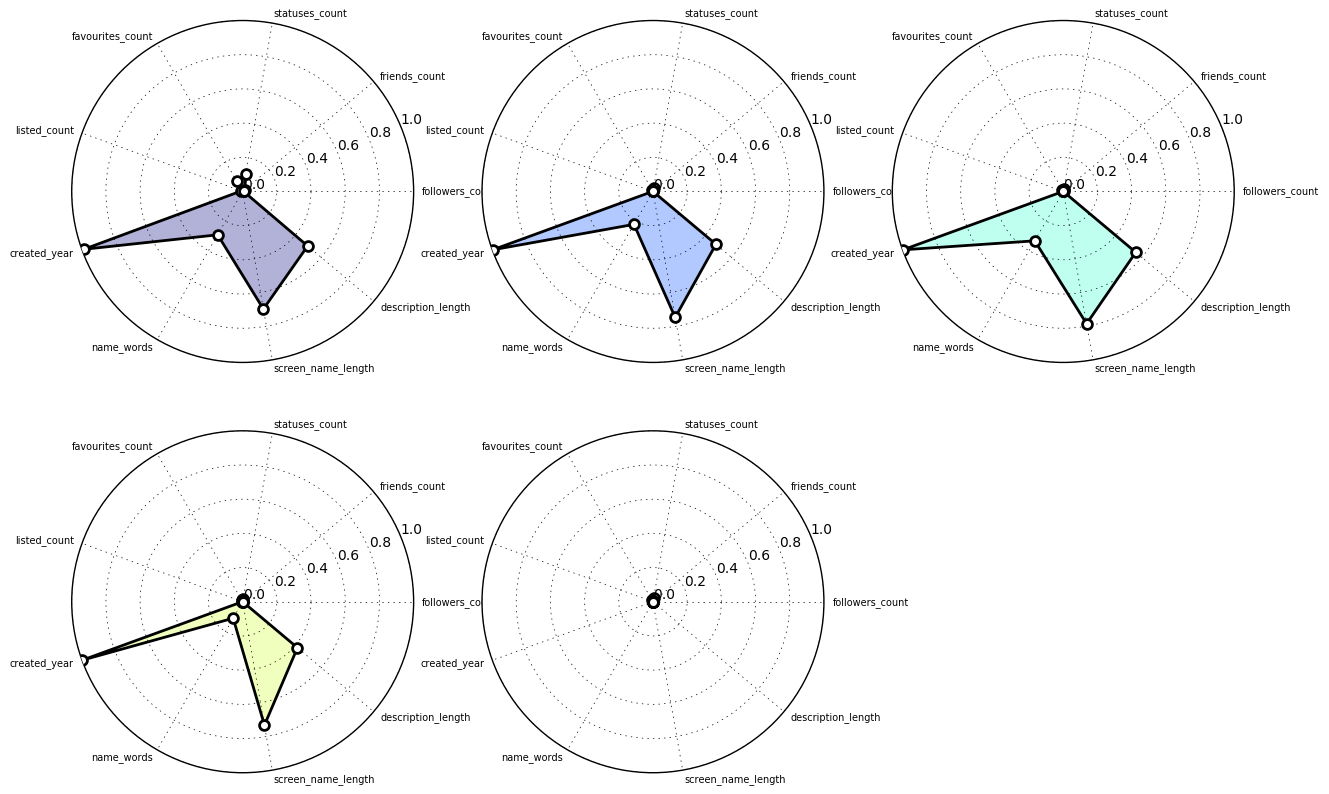

In [17]:
def radar(centroid, features, axes, color):
    # Set ticks to the number of features (in radians)
    t = np.arange(0, 2*np.pi, 2*np.pi/len(features))
    plt.xticks(t, [])

    # Set yticks from 0 to 1
    plt.yticks(np.linspace(0, 1, 6))

    # Draw polygon representing centroid
    points = [(x, y) for x, y in zip(t, centroid)]
    points.append(points[0])
    points = np.array(points)
    codes = [path.Path.MOVETO,] + [path.Path.LINETO,] * (len(centroid) - 1) + [ path.Path.CLOSEPOLY ]
    _path = path.Path(points, codes)
    _patch = patches.PathPatch(_path, fill=True, color=color, linewidth=0, alpha=.3)
    axes.add_patch(_patch)
    _patch = patches.PathPatch(_path, fill=False, linewidth = 2)
    axes.add_patch(_patch)

    # Draw circles at value points
    plt.scatter(points[:,0], points[:,1], linewidth=2, s=50, color='white', edgecolor='black', zorder=10)

    # Set axes limits
    plt.ylim(0, 1)

    # Draw ytick labels to make sure they fit properly
    for i in range(len(features)):
        angle_rad = i/float(len(features))*2*np.pi
        angle_deg = i/float(len(features))*360
        ha = "right"
        if angle_rad < np.pi/2 or angle_rad > 3*np.pi/2: ha = "left"
        plt.text(angle_rad, 1.05, features[i], size=7, horizontalalignment=ha, verticalalignment="center")

# Some additiola imports
import matplotlib
import matplotlib.path as path
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Choose some nice colors
matplotlib.rc('axes', facecolor = 'white')
# Make figure background the same colors as axes 
fig = plt.figure(figsize=(15, 15), facecolor='white')

cm = pl.get_cmap('jet')

clusters = np.unique(y)
for j, cluster in enumerate(clusters):    
    x_c = x[y == cluster]
    centroid = x_c.mean(axis=0)    
    # Use a polar axes
    axes = plt.subplot(3, 3, j + 1, polar=True)
    radar(centroid, data_df.columns.values, axes, cm(1.0 * j / k))

plt.show()

Поздравляем, Вы завершили домашние задания по модулю "Алгоритмы кластеризации". Надеемся, что это было интересно.